In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import os, re, string

from recording import Recording
from neural_net import MultiLayerPerceptron
from auxiliary import *

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import keras 

Using TensorFlow backend.


In [2]:
dh = DataHandler()

In [3]:
def train_test_split(df,speaker_id):
    X_train = np.stack(df[df.speaker_id != speaker_id].feature_vec.tolist())
    y_train = df[df.speaker_id != speaker_id].emotion_label.tolist()
    X_test = np.stack(df[df.speaker_id == speaker_id].feature_vec.tolist())
    y_test = df[df.speaker_id == speaker_id].emotion_label.tolist()
    return X_train, X_test, y_train, y_test

# Condition 1
- Global features (averaged features over time)
- Train a single classifier

In [4]:
df_1 = dh.build_feature_data(condition=1)

Excluded 08a01Ab (empty tag-file)
Excluded 08a01Wa (empty tag-file)



In [5]:
df_1.head()

,ID,feature_vec,sex,speaker_id,age,emotion_name,emotion_label
0,03a01Fa,"[-281.7693789658906, 115.77593080338801, -34.6...",m,03,31,happiness,4
1,03a01Nc,"[-265.01092879111286, 143.43997488641665, -29....",m,03,31,neutral,5
2,03a01Wa,"[-231.12855862566673, 92.83604677664029, -65.2...",m,03,31,anger,2
3,03a02Fc,"[-258.335947603345, 89.06959007175533, -35.515...",m,03,31,happiness,4
4,03a02Nc,"[-246.59932119184973, 133.65802155226476, -22....",m,03,31,neutral,5


In [ ]:
df_scores_1 = pd.DataFrame()
for i in range(10):
    scores, cms = [],[]
    for speaker_id in tqdm(sorted(set(df_1.speaker_id))):
        X_train, X_test, y_train, y_test = train_test_split(df_1,speaker_id)
        y_train = one_hot_encode(y_train, 7)

        scl = StandardScaler().fit(X_train)
        X_train = scl.transform(X_train)
        X_test = scl.transform(X_test)

        model = MultiLayerPerceptron([61,96,32,7])
        model.fit(X_train,y_train,epochs=100,val_data=(X_test,one_hot_encode(y_test,7)))
        pred = model.predict(X_test)
        scores.append(accuracy_score(y_test,pred))
        cms.append(confusion_matrix(model.predict(X_test),y_test))
    df_scores_1['score_run_%i'%(i+1)] = scores
    df_scores_1['cm_run_%i'%(i+1)] = cms
    df_scores_1['speaker'] = sorted(set(df_1.speaker_id))

df_scores_1 = df_scores_1.set_index('speaker')
df_scores_1

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.



# Condition 2
- Local features (features per phoneme)
- Train a single classifier

In [13]:
def aggregate_score(predictions,IDs,dh):
    pred, labels = [],[]
    for x in np.unique(IDs):
        p = [predictions[i] for i in range(len(IDs)) if IDs[i] == x] 
        p = np.mean(p,axis=0)
        pred.append(np.argmax(p))
        labels.append(dh.emotion_from_ID(x))
    return accuracy_score(pred,labels)

In [14]:
df_2 = dh.build_feature_data(condition=2)

Excluded 08a01Ab (empty tag-file)
Excluded 08a01Wa (empty tag-file)



In [18]:
df_scores_2 = pd.DataFrame()
for speaker_id in tqdm(sorted(set(df_2.speaker_id))):
    X_train, X_test, y_train, y_test = train_test_split(df_2,speaker_id)
    y_train = one_hot_encode(y_train, 7)
    X_train = np.squeeze(X_train)
    X_test = np.squeeze(X_test)
    
    scl = StandardScaler().fit(X_train)
    X_train = scl.transform(X_train)
    X_test = scl.transform(X_test)
    
    model = MultiLayerPerceptron([61,96,32,7])
    model.fit(X_train,y_train,epochs=100,val_data=(X_test,one_hot_encode(y_test,7)))
    
    score = aggregate_score(model.predict_proba(X_test).tolist(),
                            df_2[df_2.speaker_id == speaker_id].ID.tolist(),
                            dh)
    print(score)
    df_scores_2 = df_scores_2.append({
        'speaker': speaker_id,
        'score': score
    },ignore_index=True)

keras.backend.clear_session()
    
df_scores_2 = df_scores_2.set_index('speaker')
df_scores_2

0.6122448979591837
0.42857142857142855
0.46511627906976744
0.34210526315789475
0.45454545454545453


KeyboardInterrupt: 

# Condition 3
- Local features (features per phoneme)
- Train one classifier per phoneme

In [56]:
valid_phonemes = list(''.join([string.ascii_letters,string.digits,'@']))
df_3 = df_2[df_2.phoneme.isin(valid_phonemes)]
common_phonemes = {phoneme: count for phoneme,count in Counter(df_3.phoneme).most_common(5)}
df_3 = df_3[df_3.phoneme.isin(common_phonemes)]
common_phonemes

{'I': 1643, 'n': 1548, 'a': 1487, 't': 1265, 'm': 913}

In [63]:
df_scores_3 = pd.DataFrame()
for speaker_id in tqdm(sorted(set(df_3.speaker_id))):
    df_train = df_3[df_3.speaker_id != speaker_id]
    df_test = df_3[df_3.speaker_id == speaker_id]
    
    model_dict = {}
    for phoneme in common_phonemes:
        model = MultiLayerPerceptron([30,64,32,7])
        
        tmp = df_train[df_train.phoneme == phoneme]
        X_train = np.stack(tmp.feature_vec.tolist())
        y_train = one_hot_encode(tmp.emotion_label.tolist(),7)
        tmp = df_test[df_test.phoneme == phoneme]
        X_test = np.stack(tmp.feature_vec.tolist())
        y_test = tmp.emotion_label.tolist()
        
        scl = StandardScaler().fit(X_train)
        X_train = scl.transform(X_train)
        X_test = scl.transform(X_test)
        
        model.fit(X_train,y_train,epochs=100,val_data=(X_test,one_hot_encode(y_test,7)))
        model_dict[phoneme] = model
    
    predictions = [model_dict[row.phoneme].predict_proba(scl.transform(row.feature_vec.reshape(1,-1))) 
                   for _,row in df_test.iterrows()]
    
    score = aggregate_score(predictions,
                            df_test.ID.tolist(),
                            dh)    
    print(score)
    df_scores_3 = df_scores_3.append({
        'speaker': speaker_id,
        'score': score
    },ignore_index=True)

df_scores_3 = df_scores_3.set_index('speaker')
df_scores_3

0.5510204081632653
0.48214285714285715
0.4418604651162791
0.5526315789473685


KeyboardInterrupt: 

In [64]:
import keras
keras.backend.clear_session()

,cond_1,cond_2,cond_3
speaker,,,
03,0.591837,0.469388,0.530612
08,0.392857,0.464286,0.446429
09,0.418605,0.418605,0.395349
10,0.526316,0.552632,0.578947
11,0.563636,0.509091,0.527273
12,0.657143,0.571429,0.542857
13,0.639344,0.590164,0.622951
14,0.594203,0.550725,0.594203
15,0.589286,0.392857,0.428571


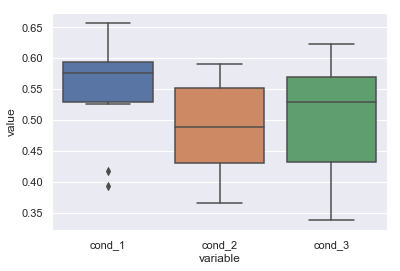

In [29]:
df_scores = df_scores_1.rename(columns={'score': 'cond_1'})
df_scores['cond_2'] = df_scores_2.score
df_scores['cond_3'] = df_scores_3.score
sns.boxplot(x="variable", y="value", data=pd.melt(df_scores))
df_scores

# Global features
- Mean over features for complete recording

In [332]:
X_train = np.stack(df_averaged_train.mean_mfcc.tolist())
y_train = df_averaged_train.emotion.tolist()

X_test = np.stack(df_averaged_test.mean_mfcc.tolist())
y_test = df_averaged_test.emotion.tolist()

lr = LogisticRegression()
lr.fit(X_train,y_train)

lr.score(X_test,y_test)

0.5263157894736842

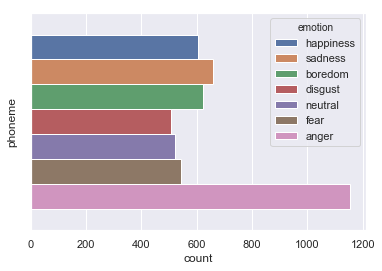

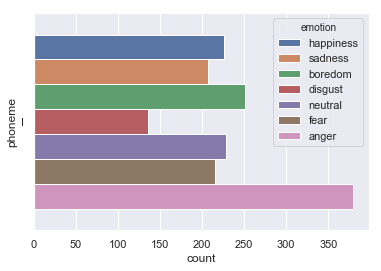

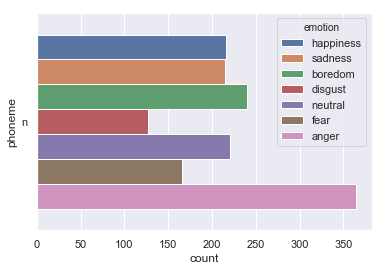

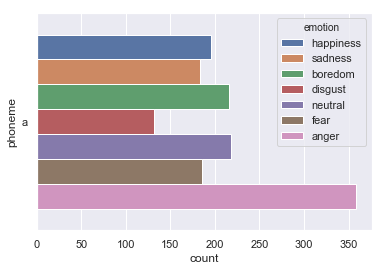

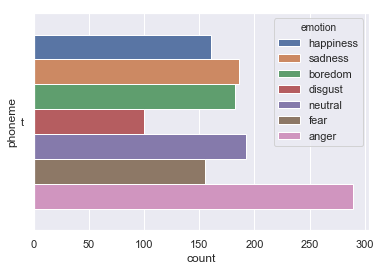

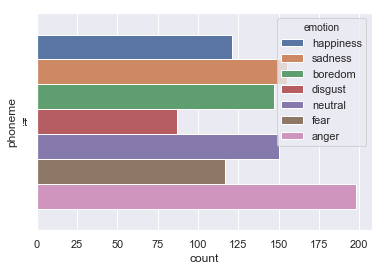

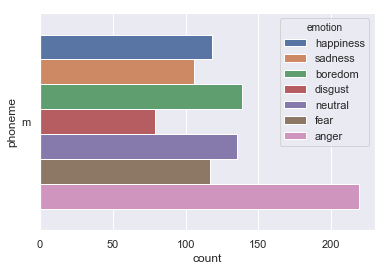

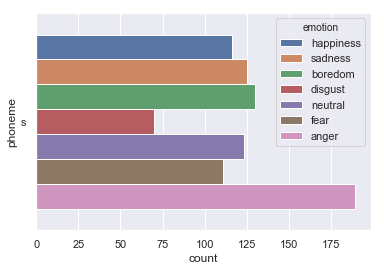

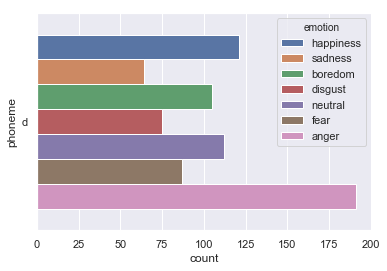

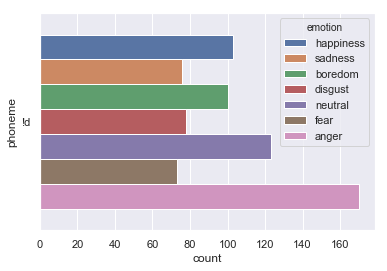

In [333]:
# phoneme distribution by emotion
emotions = set(df.emotion)
for phoneme,count in Counter(df.phoneme.tolist()).most_common(10):
    plt.figure()
    tmp = df[df.phoneme == phoneme]
    sns.countplot(data=tmp,y='phoneme',hue='emotion',orient='h',hue_order=emotions)

In [334]:
from sklearn.decomposition import FastICA,PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

df_train = df_train[df_train.phoneme.isin(valid_phonemes)]
n_phonemes = 10
df_out = pd.DataFrame()
cls_dict,pca_dict = {},{}
for i,tup in enumerate(tqdm(Counter(df_train.phoneme.tolist()).most_common(n_phonemes))):
    phoneme, count = tup
    tmp = df_train[df_train.phoneme == phoneme]
    X = np.stack(tmp.mfcc.tolist())
    
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    pca = PCA(n_components=15).fit(X)
    # X_inv_pca = pca.inverse_transform(pca.transform(X))
    # X_recon = X-X_inv_pca

    lr = LogisticRegression()
    df_out = df_out.append({
        'phoneme': phoneme,
        'count': count,
        'standard': np.round(np.mean(cross_val_score(lr,X,tmp.emotion.values,cv=5)),3),
        # 'scaled': np.round(np.mean(cross_val_score(lr,X_scaled,tmp.emotion.values,cv=4)),3),
        # 'PCA': np.round(np.mean(cross_val_score(lr,X_inv_pca,tmp.emotion.values,cv=4)),3),
        # 'Recon': np.round(np.mean(cross_val_score(lr,X_recon,tmp.emotion.values,cv=4)),3),
    },ignore_index=True)
    
    cls_dict[phoneme] = lr.fit(X,tmp.emotion.values)
    # pca_dict[phoneme] = 

df_out = df_out.append({
    'phoneme': 'Total (Average)',
    'count': df_out['count'].sum(),
    'standard': df_out.standard.mean(),
    # 'scaled': df_out.scaled.mean(),
    # 'PCA': df_out.PCA.mean(),
    # 'Recon': df_out.Recon.mean(),
},ignore_index=True)
df_out.set_index('phoneme')

,count,standard
phoneme,,
I,1532.0,0.3740
n,1457.0,0.4070
a,1393.0,0.3930
t,1185.0,0.4150
m,849.0,0.3840
s,803.0,0.3830
d,700.0,0.3590
v,600.0,0.3480
i,493.0,0.3720


In [335]:
classes = cls_dict['I'].classes_.tolist()

In [336]:
from sklearn.metrics import accuracy_score

labels, predictions = [],[]
predictions_by_phoneme = {}
for ID in set(df_test.ID):
    tmp = df_test[df_test.ID == ID]
    labels.append(classes.index(tmp.emotion.iloc[0]))
    votes = []
    for phoneme in cls_dict:
        votes_by_phoneme = []
        tmp_phonemes = tmp[tmp.phoneme == phoneme]
        if len(tmp_phonemes) > 0:
            X = np.stack(tmp_phonemes.mfcc.tolist())
            votes.extend(cls_dict[phoneme].predict_proba(X))
            votes_by_phoneme.extend(cls_dict[phoneme].predict_proba(X))
            phoneme_pred = np.argmax(np.mean(votes_by_phoneme,axis=0))
        else:
            phoneme_pred = None
            
        if phoneme in predictions_by_phoneme:
            predictions_by_phoneme[phoneme].append(phoneme_pred)
        else:
            predictions_by_phoneme[phoneme] = [phoneme_pred]
        
    predictions.append(np.argmax(np.mean(votes,axis=0)))
print('overall:',accuracy_score(labels,predictions))
for phoneme,pred in predictions_by_phoneme.items():
    label_set = [labels[i] for i in range(len(labels)) if pred[i] is not None]
    pred_set = [pred[i] for i in range(len(labels)) if pred[i] is not None]
    print('%s:'%phoneme,accuracy_score(label_set,pred_set))

overall: 0.5263157894736842
I: 0.47368421052631576
n: 0.4827586206896552
a: 0.42424242424242425
t: 0.5135135135135135
m: 0.4864864864864865
s: 0.3225806451612903
d: 0.375
v: 0.37037037037037035
i: 0.5
g: 0.4666666666666667


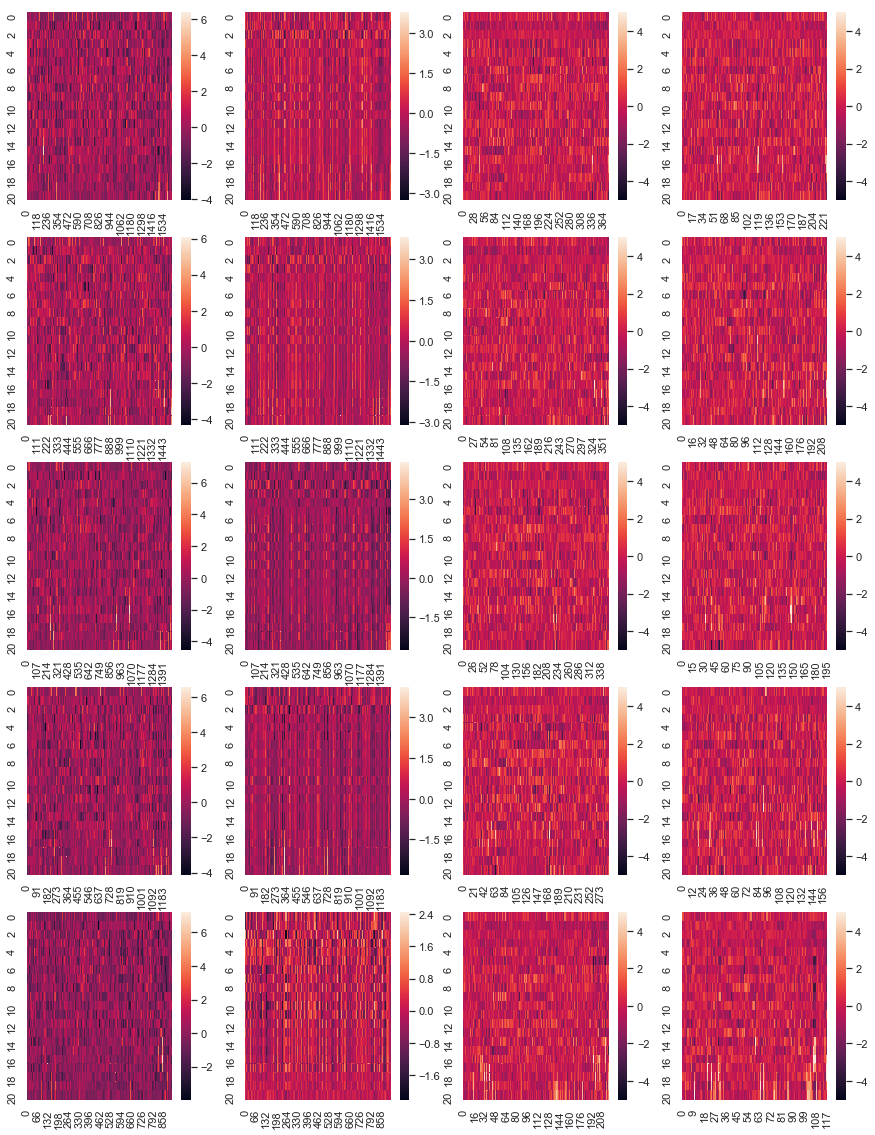

In [141]:
fig,ax = plt.subplots(ncols=4,nrows=n_phonemes,figsize=(15,4*n_phonemes))
for i,tup in enumerate(Counter(df.phoneme.tolist()).most_common(n_phonemes)):
    phoneme, count = tup
    tmp = df[(df.phoneme == phoneme)]
    stack = np.stack(tmp.mfcc.tolist())
    scaler = StandardScaler()
    stack = scaler.fit_transform(stack)
    pca = PCA(n_components=3, whiten=True)
    pca.fit(stack)
    inv_transform = pca.inverse_transform(pca.transform(stack))
    reconstruction_error = stack-inv_transform
    sns.heatmap(stack.T,ax=ax[i,0])
    sns.heatmap(inv_transform.T,ax=ax[i,1])
    sns.heatmap(reconstruction_error[tmp.emotion == 'anger'].T,ax=ax[i,2],vmin=-5,vmax=5)
    sns.heatmap(reconstruction_error[tmp.emotion == 'happiness'].T,ax=ax[i,3],vmin=-5,vmax=5)